## Import packages

In [45]:
import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
from datetime import datetime, timedelta                           # Date/time utilities
import os                                               # Operating system utilities
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

import deepSSF_model                                    # Import the .py file containing the deepSSF model                                          

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


## Import the GPS data

We only use this for selecting a spatial extent for the area we want to predict over.

In [7]:
# select the id of that data that the model was trained on
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here we want to import the spatial covariates for the extent we want to simulate over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

## NDVI

We have monthly NDVI layers for 2018 and 2019, which we import as a stack. The files don't import with a time component, so we will use a function further down that indexes them correctly.

In [8]:
# for monthly NDVI
file_path = '../mapping/cropped rasters/ndvi_monthly.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    ndvi_landscape = src.read([i for i in range(1, src.count + 1)])
    # Get the metadata of the raster
    ndvi_meta = src.meta
    raster_transform = src.transform

    # Print the metadata to check for time component
    print("Metadata:", ndvi_meta)

    # Check for specific time-related metadata
    if 'TIFFTAG_DATETIME' in src.tags():
        print("Time component found:", src.tags()['TIFFTAG_DATETIME'])
    else:
        print("No explicit time component found in metadata.")

# the rasters don't contain a time component, so we will use a function later to index the layers correctly

Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 24, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
No explicit time component found in metadata.


### Prepare the NDVI data

There are a few things we need to do to prepare the landscape layers. 

First, we need to ensure that there are no NA values in the data. For NDVI we will replace any NA values with -1 (which denotes water), as in our case that is typically why they were set to NA. 

Secondly, the model expects the covariates to on *the same scale as the training data*. We will therefore scale the NDVI data using the same max and min scaling parameters as the training data. To get these, there are some min and max print statements in the `deepSSF_train.ipynb` script. When we plot the NDVI data below we will see that the values will no longer range from 0 to 1, which is because there are values in the landscape layers that are outside of the range of the training data.

NDVI metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 24, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Affine transformation parameters:
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


Shape of the raster:
(24, 2280, 2400)


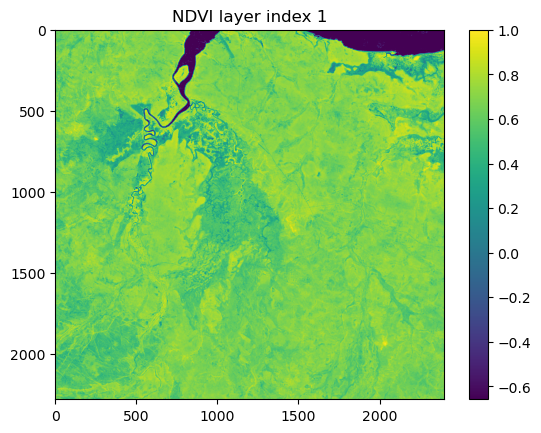

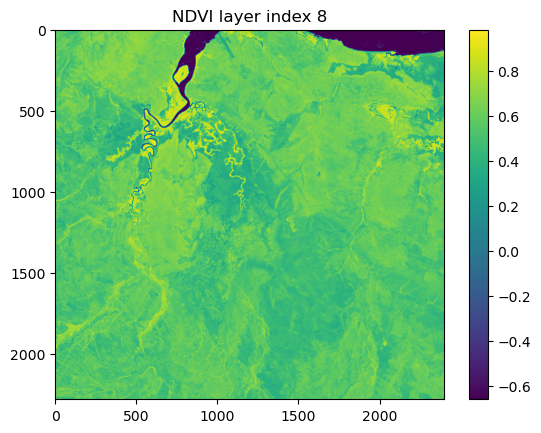

In [9]:
# Check the coordinate reference system
print("NDVI metadata:")
print(ndvi_meta)
print("\n")

# Have a look at the affine transformation parameters that are used to convert pixel 
# coordinates to geographic coordinates and vice versa
print("Affine transformation parameters:")
print(raster_transform)
print("\n")

# Check the shape (layers, row, columns) of the raster
print("Shape of the raster:")
print(ndvi_landscape.shape)

# Replace NaNs in the original array with -1, which represents water
ndvi_landscape = np.nan_to_num(ndvi_landscape, nan=-1.0)

# from the stack of local layers (training data)
ndvi_max = 0.8220
ndvi_min = -0.2772

# Convert the numpy array to a PyTorch tensor
ndvi_landscape_tens = torch.from_numpy(ndvi_landscape)

# Normalizing the data
ndvi_landscape_norm = (ndvi_landscape_tens - ndvi_min) / (ndvi_max - ndvi_min)

# Show two example layers of the scaled NDVI data
layer_index = 1
plt.imshow(ndvi_landscape_norm[layer_index,:,:].numpy())
plt.colorbar()  
plt.title(f'NDVI layer index {layer_index}')
plt.show()

layer_index = 8
plt.imshow(ndvi_landscape_norm[layer_index,:,:].numpy())
plt.colorbar()  
plt.title(f'NDVI layer index {layer_index}')
plt.show()

## Canopy cover

Canopy cover is just a single static layer.

In [10]:
# Path to the canopy cover raster file
file_path = '../mapping/cropped rasters/canopy_cover.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    canopy_landscape = src.read(1)
    # Get the metadata of the raster
    canopy_meta = src.meta

### Prepare the canopy cover data

As with the NDVI data, we need to ensure that there are no NA values in the data. 

As the canopy cover values in the landscape layer are within the same range as the training data, we see that the values range from 0 to 1.

Canopy metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of canopy raster:
(2280, 2400)


Number of NA values in the canopy raster:
0


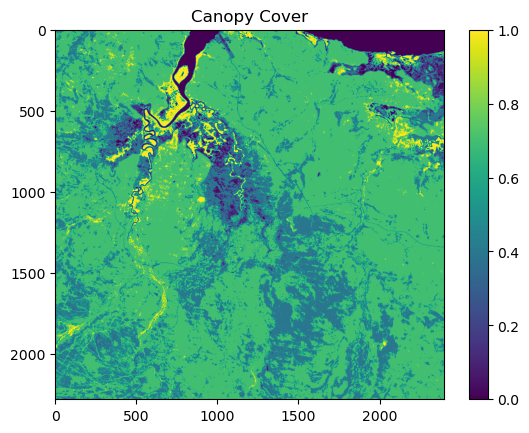

In [11]:
# Check the canopy metadata:
print("Canopy metadata:")
print(canopy_meta)
print("\n")

# Check the shape (rows, columns) of the canopy raster:
print("Shape of canopy raster:")
print(canopy_landscape.shape)
print("\n")

# Check for NA values in the canopy raster:
print("Number of NA values in the canopy raster:")
print(np.isnan(canopy_landscape).sum())

# Define the maximum and minimum canopy values from the stack of local layers:
canopy_max = 82.5000
canopy_min = 0.0

# Convert the canopy data from a NumPy array to a PyTorch tensor:
canopy_landscape_tens = torch.from_numpy(canopy_landscape)

# Normalise the canopy data:
canopy_landscape_norm = (canopy_landscape_tens - canopy_min) / (canopy_max - canopy_min)

# Visualise the normalised canopy cover:
plt.imshow(canopy_landscape_norm.numpy())
plt.colorbar()
plt.title('Canopy Cover')
plt.show()


## Herbaceous vegetation

In [12]:
# Path to the herbaceous vegetation raster file
file_path = '../mapping/cropped rasters/veg_herby.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    herby_landscape = src.read(1)
    # Get the metadata of the raster
    herby_meta = src.meta

Herbaceous metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of herbaceous raster:
(2280, 2400)


Number of NA values in the herbaceous vegetation raster:
0


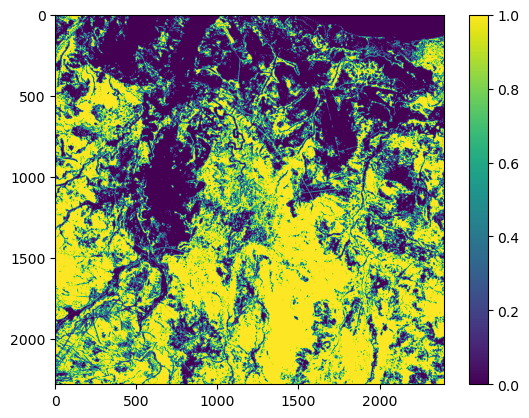

In [13]:
# Check the herbaceous metadata:
print("Herbaceous metadata:")
print(herby_meta)
print("\n")

# Check the shape (rows, columns) of the herbaceous raster:
print("Shape of herbaceous raster:")
print(herby_landscape.shape)
print("\n")

# Check for NA values in the herby raster:
print("Number of NA values in the herbaceous vegetation raster:")
print(np.isnan(herby_landscape).sum())

# Define the maximum and minimum herbaceous values from the stack of local layers:
herby_max = 1.0
herby_min = 0.0

# Convert the herbaceous data from a NumPy array to a PyTorch tensor:
herby_landscape_tens = torch.from_numpy(herby_landscape)

# Normalize the herbaceous data:
herby_landscape_norm = (herby_landscape_tens - herby_min) / (herby_max - herby_min)

# Visualize the normalised herbaceous cover:
plt.imshow(herby_landscape_norm.numpy())
plt.colorbar()
plt.show()


## Slope

In [14]:
# Path to the slope raster file
file_path = '../mapping/cropped rasters/slope.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_landscape = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta

Slope metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of slope landscape raster:
(2280, 2400)


Number of NA values in the slope raster:
0


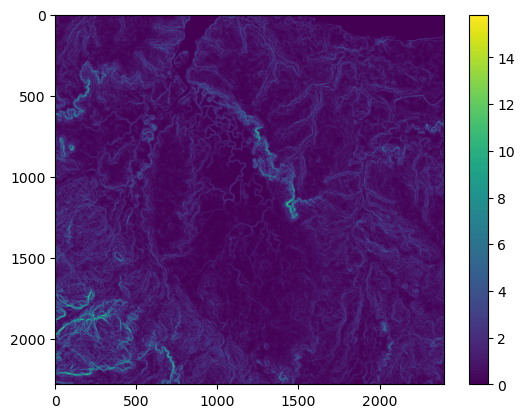

In [15]:
# Check the slope metadata:
print("Slope metadata:")
print(slope_meta)
print("\n")

# Check the shape (rows, columns) of the slope landscape raster:
print("Shape of slope landscape raster:")
print(slope_landscape.shape)
print("\n")

# Check for NA values in the slope raster:
print("Number of NA values in the slope raster:")
print(np.isnan(herby_landscape).sum())

# Replace NaNs in the slope array with 0.0 (representing water):
slope_landscape = np.nan_to_num(slope_landscape, nan=0.0)

# Define the maximum and minimum slope values from the stack of local layers:
slope_max = 12.2981
slope_min = 0.0006

# Convert the slope landscape data from a NumPy array to a PyTorch tensor:
slope_landscape_tens = torch.from_numpy(slope_landscape)

# Normalize the slope landscape data:
slope_landscape_norm = (slope_landscape_tens - slope_min) / (slope_max - slope_min)

# Visualize the slope landscape (note: displaying the original tensor, not the normalised data):
plt.imshow(slope_landscape_tens.numpy())
plt.colorbar()
plt.show()


### Convert between numpy array and raster

To check that we can go back and forth between numpy arrays (with pixel coordinates) and rasters (with geographic coordinates), we will convert the slope numpy array to a raster. 

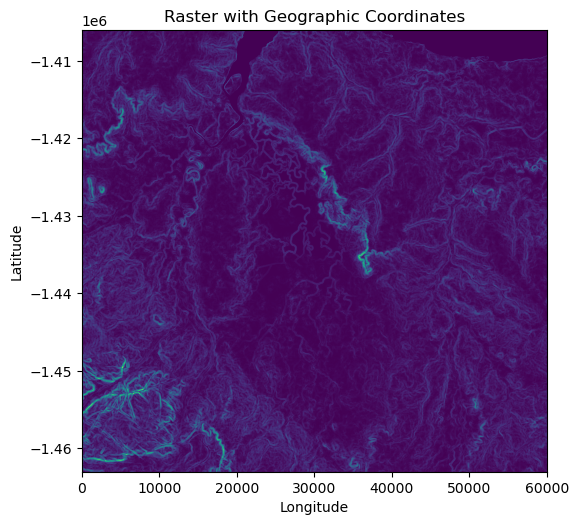

In [20]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Convert the slope_landcape (numpy array) to a raster and plot with the rasterio library
rasterio.plot.show(slope_landscape, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

# Subset function (with padding)

Now that we have our landscape layers imported, we need a way to crop out the local layers that can be fed into the deepSSF model as covariates.

Also, if our simulated individual goes off the edge of the landscape, we need to pad the landscape layers, in this case we will use values of -1 (which corresponds to water for NDVI and should be avoided) as the deepSSF model can't handle NA values.

We'll pick a location near the edge to illustrate this.

In [37]:
# Define geographic coordinates (x: easting/longitude, y: northing/latitude) near the edge
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates using the inverse transform
px, py = ~raster_transform * (x, y)

# Round the resulting pixel coordinates to the nearest integers
px, py = int(round(px)), int(round(py))

# Output the computed pixel coordinates
print(px, py)

59000.0 -1447000.0
2360 1640


Crop out the local layer, and pad with 0s if necessary.

In [38]:
window_size = 101  # Define the size of the local covariates (should be the same as the model input size)
# Calculate half the window size for centering 
# (the double slash // is integer or floor division, which rounds down to the nearest whole number)
half_window = window_size // 2 

# Determine the starting and ending indices of the window around the centre point (py, px)
row_start = py - half_window
row_stop = py + half_window + 1 # add one back on to offset the floor division
col_start = px - half_window
col_stop = px + half_window + 1 # add one back on to offset the floor division

# Create an array for the windowed subset, initialised with -1
subset = np.full((window_size, window_size), -1, dtype=slope_landscape.dtype)

# Find the valid region within the original array boundaries
valid_row_start = max(0, row_start)
valid_row_stop = min(slope_landscape.shape[0], row_stop)
valid_col_start = max(0, col_start)
valid_col_stop = min(slope_landscape.shape[1], col_stop)

# Calculate where this valid region maps into the subset array
subset_row_start = valid_row_start - row_start
subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
subset_col_start = valid_col_start - col_start
subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)

# Copy the valid part of the raster into the corresponding region of the subset array
subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
    slope_landscape[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]


Plot the local layer (of slope) in pixel coordinates, which will be 101 x 101 pixels.

Try with different coordinates above to crop out different local layers. Only the centre location is required, which is always the current location of the individual (and we are using the model to predict the next step).

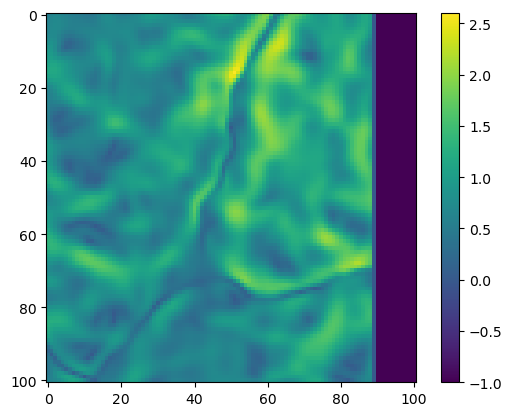

In [39]:
# plot the subset
plt.imshow(subset, cmap='viridis')
plt.colorbar()
plt.show()

## Subset function

Turn the subset code into a function for using in the simulations, although here we are operating on Pytorch tensors rather than numpy arrays, as that is what Pytorch uses.

In [40]:
def subset_raster_with_padding_torch(raster_tensor, x, y, window_size, transform):
    # Convert geographic coordinates to pixel coordinates using the inverse transform.
    px, py = ~transform * (x, y)
    
    # Round the pixel coordinates to the nearest integers.
    px, py = int(round(px)), int(round(py))
    
    # Compute half the window size to determine the extent around the central pixel.
    half_window = window_size // 2
    
    # Determine the boundaries of the window centred on the pixel coordinates.
    row_start = py - half_window
    row_stop = py + half_window + 1
    col_start = px - half_window
    col_stop = px + half_window + 1
    
    # Initialise a tensor for the subset with a padding value of -1.0.
    subset = torch.full((window_size, window_size), -1.0, dtype=raster_tensor.dtype)
    
    # Determine the valid region of the raster that falls within the window boundaries.
    valid_row_start = max(0, row_start)
    valid_row_stop = min(raster_tensor.shape[0], row_stop)
    valid_col_start = max(0, col_start)
    valid_col_stop = min(raster_tensor.shape[1], col_stop)
    
    # Calculate the corresponding region within the subset tensor.
    subset_row_start = valid_row_start - row_start
    subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
    subset_col_start = valid_col_start - col_start
    subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)
    
    # Copy the valid region from the raster tensor into the appropriate section of the subset tensor.
    subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
        raster_tensor[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]
    
    # Return the subset along with the starting column and row indices of the window.
    return subset, col_start, row_start


### Testing the subset function

Use the subset function to crop out the local layers for all covariates. Try different locations using the x and y coordinates, which are in geographic coordinates (x = easting/longitude, y = northing/latitude).

Text(0.5, 1.0, 'Slope Subset')

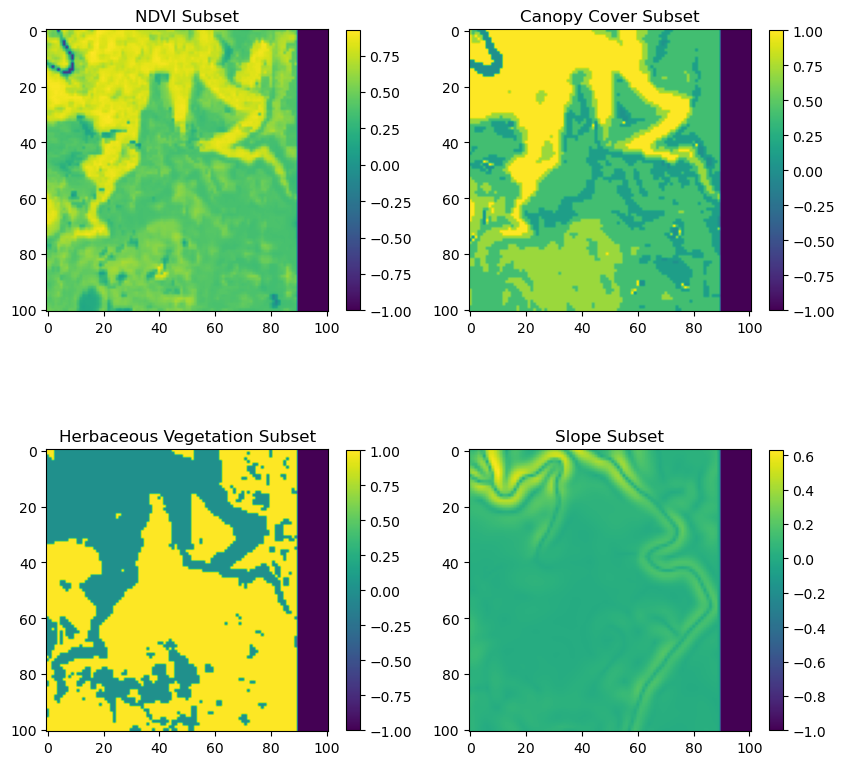

In [211]:
x = 5.9e4  # Set the easting coordinate
y = -1.425e6  # Set the northing coordinate
window_size = 101  # Define the size of the window to extract

which_ndvi = 1  # Select the NDVI layer index

# Extract subsets from various raster layers using the custom function.
# Each call centres the window at the specified (x, y) location and applies padding where necessary.
ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_landscape_norm[which_ndvi, :, :], x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_landscape_norm, x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_landscape_norm, x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_landscape_norm, x, y, window_size, raster_transform)

# Create a 2x2 grid of subplots with a fixed figure size.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the NDVI subset.
im0 = axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0], shrink=0.8)
axs[0, 0].set_title('NDVI Subset')

# Plot the Canopy Cover subset.
im1 = axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
fig.colorbar(im1, ax=axs[0, 1], shrink=0.8)
axs[0, 1].set_title('Canopy Cover Subset')

# Plot the Herbaceous Vegetation subset.
im2 = axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
fig.colorbar(im2, ax=axs[1, 0], shrink=0.8)
axs[1, 0].set_title('Herbaceous Vegetation Subset')

# Plot the Slope subset.
im3 = axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
fig.colorbar(im3, ax=axs[1, 1], shrink=0.8)
axs[1, 1].set_title('Slope Subset')


# Running the deepSSF model on the subset layers

### Set the device for the model

In [42]:
# run on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [43]:
params = deepSSF_model.ModelParams(deepSSF_model.params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128, b

In [44]:
# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_CNN_buffalo2005_2025-02-04.pt', 
                                 map_location=torch.device('cpu'),
                                 weights_only=True))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Setup simulation parameters

To get the simulation running we need a few extra functions. 

Firstly, we need to index the NDVI layers correctly, based on the time of the simulated location. We'll do this by creating a function that takes day of the year of the simulated location and returns the correct index for the NDVI layers.

Recall that Python indexes from 0, so when the month_index is equal to 2 for instance, this will index the third layer, which is for March.

In [48]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2018, 1, 1) # base date for the calculation, which is when the NDVI layers start
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    month_index = (date.month - 1) + (year_diff * 12)  # month index (0-based, accounting for year change)
    return month_index

yday = 70 # day of the year, which is March 11th
month_index = day_to_month_index(yday)
print(month_index)

2


## Stack the covariate subset layers

For testing the model.

In [212]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
subset_stack = torch.stack([ndvi_subset, canopy_subset, herby_subset, slope_subset], dim=0)
subset_stack
x1 = subset_stack
x1 = x1.unsqueeze(0)
print(x1.shape)

torch.Size([1, 4, 101, 101])


## Additional data

We also need to provide the model with the temporal covariates (hour of day and the day of the year). We will do that by creating a vector of length `n_steps` for each of these.

For the bearing we will initialise a vector of 0s, but when the model is run we will update the bearings based on the predicted steps. We will then use the bearing of the last step to predict the bearing of the next step (by estimating the turning angle as a deviation from that bearing).

In [213]:
# Define the number of simulation steps.
n_steps = 100

# Create an hour-of-day sequence and repeat it until it reaches n_steps.
hour_t2 = np.resize(range(24), n_steps)

# Convert hour-of-day values into sine and cosine components.
hour_t2_sin = np.sin(2 * np.pi * hour_t2 / 24)
hour_t2_cos = np.cos(2 * np.pi * hour_t2 / 24)

# Create a day-of-year sequence (each day repeated 24 times) and resize to n_steps.
yday_sequence = np.repeat(range(yday, 365), 24)
yday_t2 = np.resize(yday_sequence, n_steps)

# Convert day-of-year values into sine and cosine components.
yday_t2_sin = np.sin(2 * np.pi * yday_t2 / 365)
yday_t2_cos = np.cos(2 * np.pi * yday_t2 / 365)

# Initialise a bearing vector with zeroes for all simulation steps, 
# which will be updated during the simulation.
bearing = np.repeat(0, n_steps)

# Convert the arrays to PyTorch tensors.
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()
bearing = torch.tensor(bearing).float()

# Stack the sine and cosine tensors along a new dimension to form the temporal feature tensor.
x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor), dim=1)

# Print the shape of the tensor: (number of steps, number of features).
print(x2_full.shape)

# Display the temporal features for a specific time step (e.g. index 59).
print(f'Temporal information for a single step: {x2_full[59, :]}')


torch.Size([100, 4])
Temporal information for a single step: tensor([ 0.2588, -0.9659,  0.9456,  0.3253])


### Functions to recover the hour and yday

Occasionally we will want to recover the hour and day of the year from the sine and cosine terms, so we create a few helper functions to do this.

In [214]:
def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (24 * theta) / (2 * np.pi) % 24
    return hour


def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi) % 365
    return yday

## Test the model on the subset layers

Now we have the covariates ready, we can test the model on them.

In [215]:
# Select a specific time step to test the model, 
# which just indexes the temporal features in this case
step = 17

# Run the model with the selected input tensors
# Create some extra dimensions to match the model input shape
test = model((x1, x2_full[step,:].unsqueeze(0), bearing[step].unsqueeze(0).unsqueeze(0)))
print(test.shape)

torch.Size([1, 101, 101, 2])


### View the model output

We first check what the hour and yday values were that were inputted to the model, and then plot the habitat selection, movement and next-step predictions from the model.

As convolution filters produce artifacts at the edges of the image, we will crop the habitat selection predictions to remove these. We do this as those edge values are often quite different to the rest of the prediction outputs and change the colour scale, and we only do this when plotting the habitat selection and next-step predictions.

We will also crop out the padding we added to the landscape layers at the edges of the landscape covariates. This we also do during the simulation, as we don't want cells outside the extent of the landscape to be selected as the next step, i.e., we create a 'hard' or 'reflective' boundary.

The hour of the step is 17
The day of the year of the step is 70


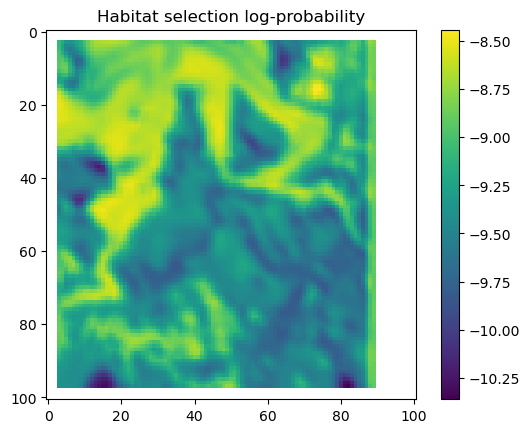

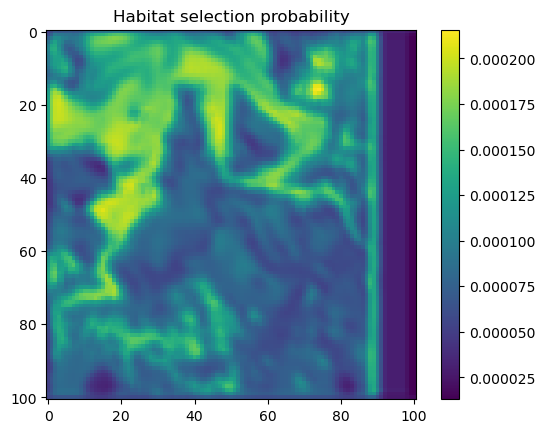

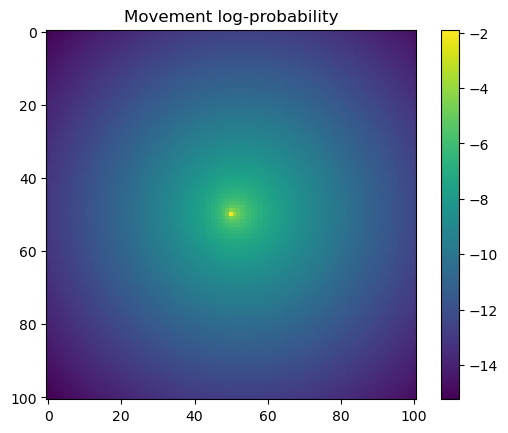

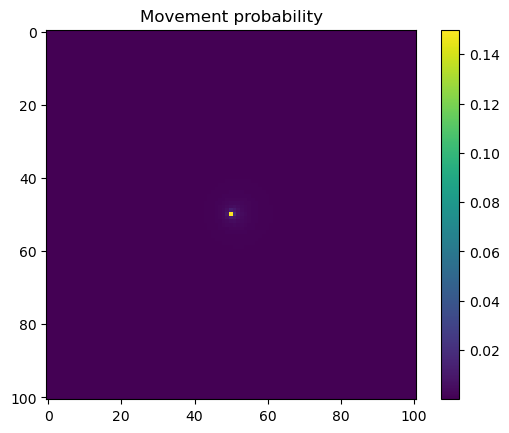

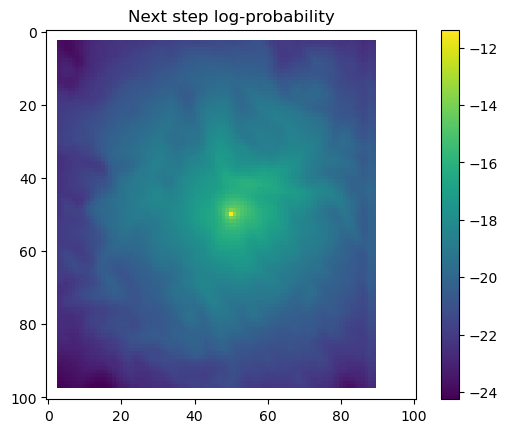

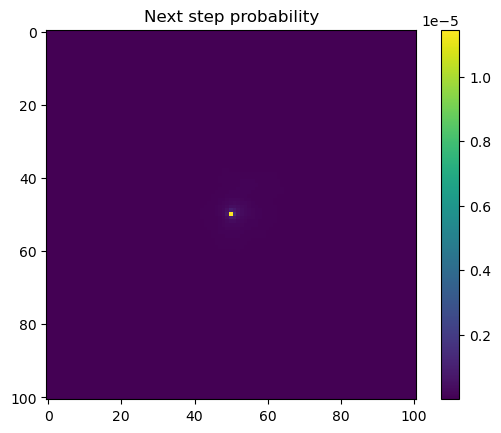

In [216]:
# Extract the temporal features for the specified step and convert to a NumPy array.
x2_step = x2_full[step, :].detach().numpy()

# Unpack the sine and cosine components for both hour and day-of-year.
hour_t2_sin, hour_t2_cos, yday_t2_sin, yday_t2_cos = x2_step

# Recover and print the hour value for the step using the sine and cosine components.
hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print(f'The hour of the step is {round(hour_t2)}')

# Recover and print the day-of-year value for the step using the sine and cosine components.
yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print(f'The day of the year of the step is {round(yday_t2)}')

# Extract model predictions from the output tensor.
# hab_density: predicted habitat density; move_density: predicted movement density.
hab_density = test.detach().numpy()[0, :, :, 0]  # habitat density
move_density = test.detach().numpy()[0, :, :, 1]   # movement density

# Compute the next step probability by summing habitat and movement densities.
next_step = hab_density + move_density

# Create border masks for the x and y coordinates to control the colour scale.
x_mask = np.ones_like(hab_density)
y_mask = np.ones_like(hab_density)

# Mask out the edge cells by setting them to negative infinity.
x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

# Create an edge mask using the NDVI subset as a template.
# Replace padding values (-1) with NaN so they do not affect visualisation.
edge_mask = ndvi_subset
edge_mask = torch.where(edge_mask == -1, torch.tensor(float('nan')), 1).numpy()

# Plot the habitat selection log-probability after applying the border and edge masks.
plt.imshow(hab_density * x_mask * y_mask * edge_mask)
plt.colorbar()
plt.title('Habitat selection log-probability')
plt.show()

# Plot the habitat selection probability
plt.imshow(np.exp(hab_density))
plt.colorbar()
plt.title('Habitat selection probability')
plt.show()

# Plot the movement log-probability
plt.imshow(move_density)
plt.colorbar()
plt.title('Movement log-probability')
plt.show()

# Plot the movement probability
plt.imshow(np.exp(move_density))
plt.colorbar()
plt.title('Movement probability')
plt.show()

# Plot the next step log-probability with the masks applied.
plt.imshow(next_step * x_mask * y_mask * edge_mask)
plt.colorbar()
plt.title('Next step log-probability')
plt.show()

# Plot the next step probability.
plt.imshow(np.exp(next_step))
plt.colorbar()
plt.title('Next step probability')
plt.show()


## Sample from the probability surface

I.e., choose the individual's next step

Sum of probability values: 1.0
Sampled probability values: 0.0007904381744779012
Sampled coordinates: (57, 47)


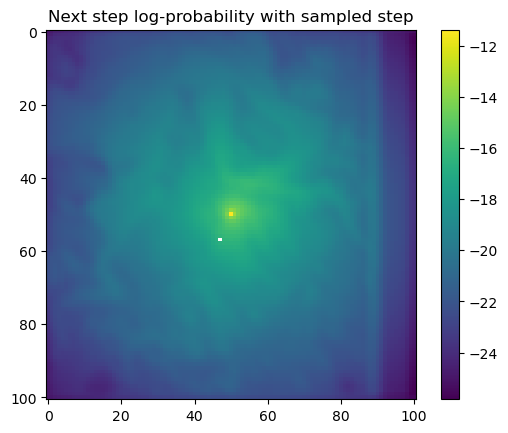

In [228]:
# sample from the array values
next_step_exp = np.exp(next_step)
# replace NaNs with 0 (which have no probability of being selected)
next_step_exp = np.nan_to_num(next_step_exp, nan=0.)
# normalise the array to sum to 1
next_step_exp = next_step_exp/np.sum(next_step_exp)
print(f'Sum of probability values: {np.sum(next_step_exp)}') # should be 1

# Flatten the probability surface into a vector (1D array)
flat_prob_surface = next_step_exp.flatten()
# print(flat_prob_surface)

# Generate the corresponding cell indices for the flattened array
indices = np.arange(flat_prob_surface.size)
# print(indices)

# Sample from the flattened probability surface
sampled_index = np.random.choice(indices, p=flat_prob_surface)
# print(sampled_index)

# Print the probability of the sampled index
print(f'Sampled probability values: {flat_prob_surface[sampled_index]}')

# Convert the sampled index back to 2D coordinates
sampled_coordinates = np.unravel_index(sampled_index, next_step_exp.shape)
print("Sampled coordinates:", sampled_coordinates)

# Create a copy of the next step probability surfaces for plotting
# The log-probability surface is used for visualisation as it's more informative
step_log_prob = next_step.copy()
# The probability surface is used for sampling, but it's not as visually informative
# step_log_prob = next_step_exp.copy()

# Set the pixel of the next step, which is at (x, y) to -inf
step_log_prob[sampled_coordinates] = -np.inf

# Plot the next step log-probability with the sampled step highlighted
plt.imshow(step_log_prob)
plt.colorbar()
plt.title('Next step log-probability with sampled step')
plt.show()

## Create a number of next steps

Loop over the sampling process to take many next steps from the next step probability surface to see where the predicted next steps are

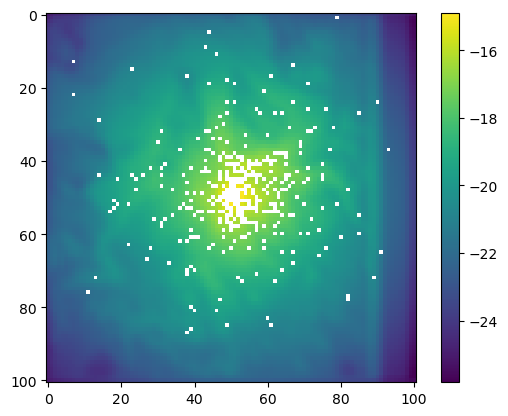

In [229]:
for i in range(500):

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_prob_surface)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, next_step_exp.shape)

    # Set the pixel of the next step, which is at (x, y) to -inf
    step_log_prob[sampled_coordinates] = -np.inf

plt.imshow(step_log_prob)
plt.colorbar()
plt.show()

## Return sampled point to geographic coordinates

When simulating, we don't want to just the pixel values (as they are in reference to the local layer), but we want to return the geographic coordinates of the next step and store those.

In [240]:
print(f'Starting location in local layer pixel coordinates:          {x ,y}')
print(f'Starting location in landscape layer pixel coordinates:      {px, py}')
print(f'Sampled next step location (local layer pixel coordinates):  {sampled_coordinates}')
print(f'landscape pixel locations at the origin of the local layer:  {row_start, col_start}')

# Add the sampled coordinates to the landscape pixel locations at the origin of the local layer
# THE Y COORDINATE (row) COMES FIRST
new_px = origin_x + sampled_coordinates[1]
new_py = origin_y + sampled_coordinates[0]

print(f'landscape pixel coordinates of the sampled next step:        {new_px, new_py}')

# Convert landscape pixel coordinates to geographic coordinates
new_x, new_y = raster_transform * (new_px, new_py)

print(f'Landscape geograhic coordinates at the next step:            {new_x, new_y}')

Starting location in local layer pixel coordinates:          (59000.0, -1425000.0)
Starting location in landscape layer pixel coordinates:      (2360, 1640)
Sampled next step location (local layer pixel coordinates):  (53, 36)
landscape pixel locations at the origin of the local layer:  (1590, 2310)
landscape pixel coordinates of the sampled next step:        (2346, 763)
Landscape geograhic coordinates at the next step:            (58650.0, -1425075.0)


# Full trajectory function

In [59]:
def simulate_trajectory(global_raster_tensors, 
                        scalars_to_grid,
                        # additional_data_tensor,
                        bearing,
                        window_size, 
                        x_loc, 
                        y_loc,
                        global_raster_transform):
    
    results = [subset_raster_with_padding_torch(raster_tensor, x=x_loc, y=y_loc, window_size=window_size, transform=global_raster_transform) for raster_tensor in global_raster_tensors]
    
    # Unpacking the results
    subset_rasters_tensors, origin_xs, origin_ys = zip(*results)
    # print(subset_rasters_tensors)

    
    # Stack the processed tensors along a new dimension (e.g., dimension 0)
    x1 = torch.stack(subset_rasters_tensors, dim=0)
    x1 = x1.unsqueeze(0)
    # print(x1.shape)

    single_layer = x1[0, 0, :, :]
    # plt.imshow(single_layer.detach().numpy()[:,:])
    # plt.colorbar()
    # plt.show()

    # create masking layer to remove outside of the extent
    mask = torch.where(single_layer == -1, torch.tensor(float('nan')), 1)
    
    # test_cat_exp = torch.exp(test_cat)

    # extract NaNs to pad and make masking layer
    x2 = scalars_to_grid
    # x3 = additional_data_tensor

    x3 = bearing

    test = model((x1, x2, x3))
    # print(test.shape)

    hab_log_prob = test[:, :, :, 0]
    move_log_prob = test[:, :, :, 1]

    step_log_prob = (hab_log_prob + move_log_prob)
    step_log_prob = step_log_prob * mask

    hab_log_prob = hab_log_prob.squeeze()
    move_log_prob = move_log_prob.squeeze()
    step_log_prob = step_log_prob.squeeze()

    # sample from the array values
    step_prob = torch.exp(step_log_prob)
    step_prob = torch.nan_to_num(step_prob, nan=0.)
    step_prob_norm = step_prob/torch.sum(step_prob)
    # print(test_cat_exp)
    # print(torch.sum(test_cat_exp))

    # plt.imshow(test_cat_exp.detach().numpy()[:,:])
    # plt.colorbar()
    # plt.show()

    # Flatten the probability surface
    flat_step_prob_norm = step_prob_norm.flatten().detach().numpy()
    # print(flat_prob_surface)

    # Generate the corresponding indices for the flattened array
    indices = np.arange(flat_step_prob_norm.size)

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_step_prob_norm)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, step_prob_norm.shape)

    # THE Y COORDINATE COMES FIRST in the sampled coordinates
    new_px = origin_xs[0] + sampled_coordinates[1]
    new_py = origin_ys[0] + sampled_coordinates[0]

    # Convert geographic coordinates to pixel coordinates
    new_x, new_y = raster_transform * (new_px, new_py)

    # Place the sampled location at a random point within the cell (rather than the centre)
    # new_x = new_x + np.random.uniform(-12.5, 12.5)
    # new_y = new_y + np.random.uniform(-12.5, 12.5)

    # instead of the uniform, sample from a normal distribution with mean 0 and sd 6.5, 
    # which are the parameters where the cell contains ~ 95% of density
    # if it's outside the bounds of the cell, resample
    while True:
        jitter_x = np.random.normal(0, 6.5)
        if -12.5 <= jitter_x <= 12.5:
            break

    # Sample jitter for new_y and ensure it is within bounds
    while True:
        jitter_y = np.random.normal(0, 6.5)
        if -12.5 <= jitter_y <= 12.5:
            break

    # Add the valid jitter to new_x and new_y
    new_x = new_x + jitter_x
    new_y = new_y + jitter_y

    # print(new_x, new_y)

    # return new_x, new_y, step_prob
    return new_x, new_y, hab_log_prob, move_log_prob, step_log_prob, sampled_coordinates[1], sampled_coordinates[0]


## Call the function

In [60]:
global_raster_list = [ndvi_landscape_norm[which_ndvi,:,:], canopy_landscape_norm, herby_landscape_norm, slope_landscape_norm]
x2 = x2_full[3,:].unsqueeze(0)
# x3 = x2
bearing_step = bearing[3].unsqueeze(0).unsqueeze(0)
print(x2)
print(bearing.shape)

simulate_trajectory(global_raster_tensors=global_raster_list,
                    scalars_to_grid=x2,
                    # additional_data_tensor=x3,
                    bearing=bearing_step,
                    window_size=101,
                    x_loc=41969,
                    y_loc=-1.435671e+06,
                    global_raster_transform=raster_transform)

tensor([[ 0.7071,  0.7071, -0.9942,  0.1074]])
torch.Size([1000])


(41294.6246129592,
 -1435876.496104774,
 tensor([[-10.9798, -10.8766, -10.6232,  ..., -10.8568, -11.0595, -11.0156],
         [-11.2253, -10.9846, -10.5650,  ..., -10.8998, -11.1774, -10.9955],
         [-10.9037, -10.5621,  -9.9899,  ..., -10.4822, -10.9105, -10.8701],
         ...,
         [-10.6507, -10.2017,  -9.7033,  ...,  -9.8946, -10.2207, -10.4745],
         [-11.0968, -10.9636, -10.6533,  ..., -10.7428, -10.8820, -10.8480],
         [-11.2361, -11.2483, -11.1158,  ..., -11.1469, -11.1915, -11.0522]],
        dtype=torch.float64, grad_fn=<SqueezeBackward0>),
 tensor([[-15.7534, -15.6741, -15.5955,  ..., -15.2336, -15.3086, -15.3843],
         [-15.6785, -15.5983, -15.5188,  ..., -15.1534, -15.2293, -15.3059],
         [-15.6043, -15.5233, -15.4429,  ..., -15.0738, -15.1506, -15.2282],
         ...,
         [-15.6471, -15.5668, -15.4871,  ..., -15.1587, -15.2349, -15.3118],
         [-15.7220, -15.6425, -15.5637,  ..., -15.2389, -15.3142, -15.3902],
         [-15.7976, -15.71

# Generate trajectory

## Setup parameters

In [61]:
# Get today's date for saving figures
today_date = datetime.today().strftime('%Y-%m-%d')

# Setup the simulation parameters
n_steps = 3000
starting_yday = 206

# starting location of buffalo 2005
start_x = 41969.310875
start_y = -1.435671e+06

global_raster_list = [ndvi_landscape_norm, canopy_landscape_norm, herby_landscape_norm, slope_landscape_norm]
print(global_raster_list[0].shape)
window_size = 101
global_raster_transform = raster_transform


torch.Size([24, 2280, 2400])


## Create simulation inputs from the parameters

In [62]:
x = np.repeat(0., n_steps)
y = np.repeat(0., n_steps)
# print(x)

x[0], y[0] = start_x, start_y
# print(x, y)

# Create sequence of steps
step = range(1, n_steps)
# print(step)

# hour of the day (hour) sequence
hour_t2 = np.resize(range(24), n_steps)
# print(hour_t2)
# convert to sine and cosine
hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

# Create the day of the year sequences
yday_t2 = np.repeat(range(starting_yday, starting_yday + 365), 24)
yday_t2 = np.resize(yday_t2, n_steps)
# print(yday_t2)
# convert to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

# bearing vector
bearing = np.repeat(0., n_steps)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
bearing_tensor = torch.tensor(bearing).float()

# Stack tensors column-wise to create a tensor of shape [n_steps, 4]
x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor), dim=1)
# x3_full = x2_full
# print(head(x2_full))

# List to hold filenames of saved images
filenames_hab = []
filenames_move = []
filenames_step = []

### Select the appropriate NDVI layer from the yday

In [63]:
# Initialize variables to cache the previous yday and month index
previous_yday = None
month_index = None

day_to_month_index(500)

yday_sequence_1 = np.repeat(range(starting_yday, starting_yday + 365), 24)
print(yday_sequence_1)
print(len(yday_sequence_1))

[206 206 206 ... 570 570 570]
8760


## Trajectory loop

In [64]:
for i in range(1, n_steps):

    x_loc = x[i-1]
    y_loc = y[i-1]

    # calculate the bearing from the previous location
    if i > 1:
        bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
    else:
        bearing_rad = np.random.uniform(-np.pi, np.pi)

    # Store the bearing in the vector
    bearing[i-1] = bearing_rad
    # print("Bearing[i-1]", bearing[i-1])

    bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)

    x2 = x2_full[i-1,:].unsqueeze(dim=0)
    # print(x2)

    # Determine the month index based on the day of the year
    day_of_year = yday_t2[i-1]
    if day_of_year != previous_yday:
        month_index = day_to_month_index(day_of_year)
        previous_yday = day_of_year

    # print(f'Day of the year: {day_of_year}')
    month_index = day_to_month_index(day_of_year)
    # print(f'Month index: {month_index}')

    global_raster_list = [ndvi_landscape_norm[month_index,:,:], canopy_landscape_norm, herby_landscape_norm, slope_landscape_norm]
    
    sim_outputs = simulate_trajectory(global_raster_tensors=global_raster_list,
                                      scalars_to_grid=x2,
                                      # additional_data_tensor=x2,
                                      bearing=bearing_tensor,
                                      window_size=101,
                                      x_loc=x_loc,
                                      y_loc=y_loc,
                                      global_raster_transform=global_raster_transform)
    
    new_x, new_y, hab_log_prob, move_log_prob, step_log_prob, px, py = sim_outputs
    
    # print(new_x, new_y)
    # print(px, py)

    new_bearing = np.arctan2(new_y - y_loc, new_x - x_loc)
    # print(new_bearing)

    x[i] = new_x
    y[i] = new_y
    
    
    # ### PLOTTING
    # # Create the mask for x and y coordinates
    # x_mask = np.ones_like(hab_density)
    # y_mask = np.ones_like(hab_density)

    # # mask out cells on the edges that affect the colour scale
    # x_mask[:, :3] = -np.inf
    # x_mask[:, 98:] = -np.inf
    # y_mask[:3, :] = -np.inf
    # y_mask[98:, :] = -np.inf

    # ## Habitat probability surface
    # # normalise the raster for plotting
    # hab_log_prob_norm = hab_log_prob/-torch.sum(hab_log_prob)

    # # convert to numpy array
    # hab_log_prob_norm = hab_log_prob_norm.detach().numpy()[:,:]

    # # Create the mask for x and y coordinates
    # hab_log_prob_norm = hab_log_prob_norm * x_mask * y_mask

    # # Save the figure
    # filename_hab = f"outputs/dl_prob_maps/ta_mix/id{buffalo_id}_hab_log_prob_norm_{today_date}_{i}.png"
    # plt.figure()  # Create a new figure
    # plt.imshow(hab_log_prob_norm)
    # plt.colorbar()
    # plt.draw()  # Ensure the plot is rendered
    # plt.savefig(filename_hab, dpi=300)
    # # plt.show()
    # plt.close()  # Close the figure to free memory
    # # Add filename to the list
    # filenames_hab.append(filename_hab)  

    # ### Movement probability surface
    # # normalise the raster for plotting
    # move_log_prob_norm = move_log_prob/-torch.sum(move_log_prob)
    # # convert to numpy array
    # move_log_prob_norm = move_log_prob_norm.detach().numpy()[:,:]
    # # Save the figure
    # filename_move = f"outputs/dl_prob_maps/id{buffalo_id}_move_log_prob_norm_{today_date}_{i}.png"
    # plt.figure()  # Create a new figure
    # plt.imshow(move_log_prob_norm)
    # plt.colorbar()
    # plt.draw()  # Ensure the plot is rendered
    # plt.savefig(filename_move, dpi=300)
    # # plt.show()
    # plt.close()  # Close the figure to free memory
    # # Add filename to the list
    # filenames_move.append(filename_move)  


    # ### Step selection probability surface
    # # normalise the raster for plotting
    # log_prob_surface_norm = step_log_prob/-torch.sum(step_log_prob)
    # # convert to numpy array
    # log_prob_surface_norm = log_prob_surface_norm.detach().numpy()[:,:]

    # # Set the pixel of the next step, which is at (x, y) to 0
    # log_prob_surface_norm[py, px] = -0.0001

    # # Create the mask for x and y coordinates
    # log_prob_surface_norm = log_prob_surface_norm * x_mask * y_mask

    # # Save the figure
    # filename = f"outputs/dl_prob_maps/ta_mix/id{buffalo_id}_step_log_prob_norm_{today_date}_{i}.png"
    # plt.figure()  # Create a new figure
    # plt.imshow(log_prob_surface_norm)
    # plt.colorbar()
    # plt.draw()  # Ensure the plot is rendered
    # plt.savefig(filename, dpi=300)
    # # plt.show()
    # plt.close()  # Close the figure to free memory
    # # Add filename to the list
    # filenames_step.append(filename)  


    # ### Step selection probability surface (exp)
    # # normalise the raster for plotting
    # prob_surface_norm = torch.exp(step_log_prob)/torch.sum(torch.exp(step_log_prob))
    # # log_prob_surface_norm = step_log_prob/-torch.sum(step_log_prob)
    # # convert to numpy array
    # prob_surface_norm = prob_surface_norm.detach().numpy()[:,:]

    # # Set the pixel of the next step, which is at (x, y) to 0
    # prob_surface_norm[py, px] = 0.0

    # # Save the figure
    # filename = f"outputs/dl_prob_maps/ta_mix/id{buffalo_id}_prob_surface_{today_date}_{i}.png"
    # plt.figure()  # Create a new figure
    # plt.imshow(prob_surface_norm)
    # plt.colorbar()
    # plt.draw()  # Ensure the plot is rendered
    # # plt.savefig(filename, dpi=300)
    # plt.show()
    # plt.close()  # Close the figure to free memory
    # # Add filename to the list
    # filenames_step.append(filename)  


### Checking the model outputs

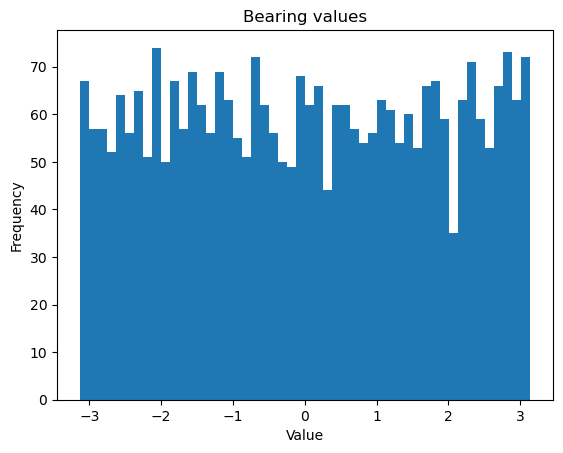

(3000,)


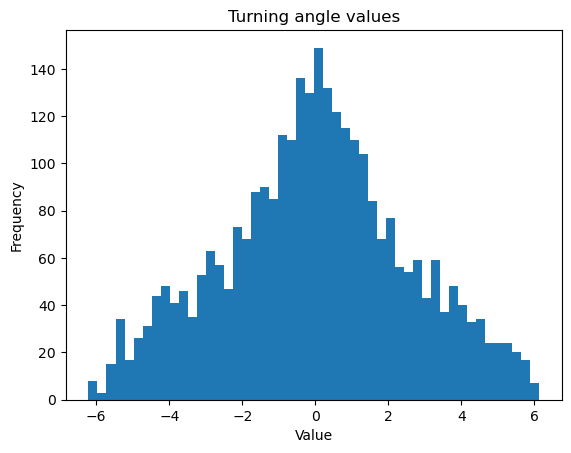

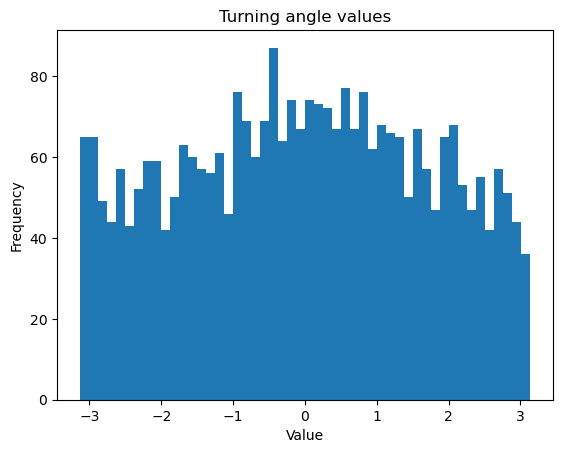

(3000,)


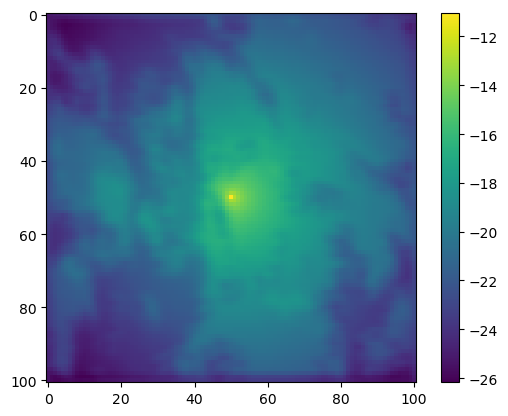

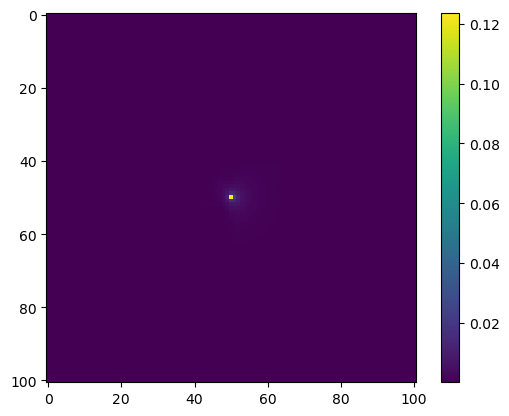

In [65]:
# print(bearing)
plt.hist(bearing[x>0], bins=50) #, edgecolor='black'
plt.title('Bearing values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

print(bearing.shape)

# Calculate the turning angle (difference between consecutive values)
ta = np.diff(bearing[x>0])
ta = np.insert(ta, 0, 0)
plt.hist(ta, bins=50) #, edgecolor='black'
plt.title('Turning angle values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

ta_corr = np.where(ta > np.pi, ta - (2 * np.pi), 
                   np.where(ta < -np.pi, ta + (2 * np.pi), ta))


plt.hist(ta_corr, bins=50) #, edgecolor='black'
plt.title('Turning angle values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

print(ta.shape)

step_log_prob_norm = step_log_prob/torch.sum(step_log_prob)
# print(step_log_prob_norm)

plt.imshow(step_log_prob.detach().numpy()[:,:])
plt.colorbar()
plt.show()

# check for NaN values
# print(torch.isnan(step_log_prob_norm).any())

step_prob = torch.exp(step_log_prob)

step_prob_norm = step_prob/torch.sum(step_prob)
# print(torch.sum(step_prob_norm))

plt.imshow(step_prob_norm.detach().numpy()[:,:])
plt.colorbar()
plt.show()

# # Create a histogram
# plt.hist(step_prob_norm.detach().numpy()[:,:], bins=100) #, edgecolor='black'
# # Add title and labels
# plt.title('Histogram Example')
# plt.xlabel('Value')
# plt.ylabel('Frequency')

# Show the plot
plt.show()

# ndvi_landscape_norm = (ndvi_landscape_tens - ndvi_min) / (ndvi_max - ndvi_min)

## Plot the simulated trajectory

3000
3000


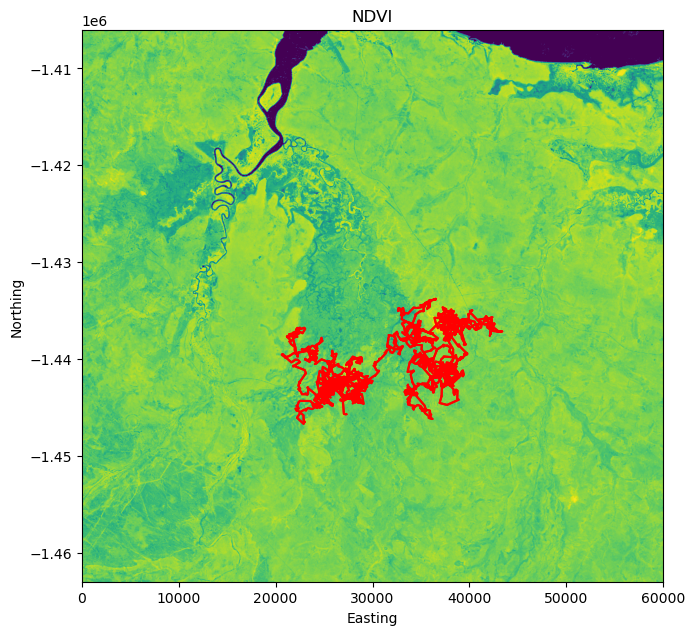

In [66]:
# Actual number of locations before there were NaNs
# print(x)
print(x[x>0].shape[0])

# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
# Plot the raster
show(ndvi_landscape[which_ndvi,:,:], transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('NDVI')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Plot the simulated trajectory
no_sim_points = np.min([x[x>0].shape[0], y[y<0].shape[0]])
print(no_sim_points)
plt.plot(x[1:no_sim_points], y[1:no_sim_points], color = 'red')
plt.plot(x[1:no_sim_points], y[1:no_sim_points], color = 'red')
# Show the plot
plt.show()


## Write the trajectory to a csv

### Only run this once otherwise it will create duplicates

In [67]:
# Combine vectors into a DataFrame
trajectory_df = pd.DataFrame({'x': x[x>0], 
                              'y': y[x>0], 
                              'hour': hour_t2[x>0], 
                              'yday': yday_t2[x>0], 
                              'bearing': bearing[x>0], 
                              'ta': ta})

n_steps_actual = x[x>0].shape[0]

# Save the DataFrame to a CSV file
index = 1
csv_filename = f'outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'

# Check if the file already exists and find a new name if necessary
while os.path.exists(csv_filename):
    csv_filename = f'outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'
    index += 1

print(csv_filename)
trajectory_df.to_csv(csv_filename, index=True)

outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id2005_3000steps_5_2024-09-29.csv


## Multiple trajectories in a loop

In [68]:
# Setup the simulation parameters

# here we just run a couple simulations to show that it's working
n_trajectories = 5
n_steps = 1000
starting_yday = 206

# global_raster_list = [ndvi_landscape_norm, canopy_landscape_norm, herby_landscape_norm, slope_landscape_norm]
window_size = 101
global_raster_transform = raster_transform

# Looping over individuals

for j in range(1, n_trajectories+1):

    # Setup the vectors used in the prediction function
    x = np.repeat(0., n_steps)
    y = np.repeat(0., n_steps)
    x[0], y[0] = start_x, start_y

    # Create sequence of steps
    step = range(1, n_steps)

    # hour of the day (hour) sequence
    hour_t2 = np.resize(range(24), n_steps)
    # convert to sine and cosine
    hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
    hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

    # Create the day of the year sequences
    yday_t2 = np.repeat(range(starting_yday, starting_yday + 365), 24)

    yday_t2 = np.resize(yday_t2, n_steps)
    # convert to sine and cosine
    yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
    yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

    # bearing vector
    bearing = np.repeat(0., n_steps)

    # Convert lists to PyTorch tensors
    hour_t2_tensor = torch.tensor(hour_t2).float()
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
    yday_t2_tensor = torch.tensor(yday_t2).float()
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
    bearing_tensor = torch.tensor(bearing).float()

    # Stack tensors column-wise to create a tensor of shape [n_steps, 4]
    x2_full = torch.stack((hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor), dim=1)

    # Initialize variables to cache the previous yday and month index
    previous_yday = None
    month_index = None


    # simulation loop
    
    for i in range(1, n_steps):

        x_loc = x[i-1]
        y_loc = y[i-1]

        # calculate the bearing from the previous location
        if i > 1:
            bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
        else:
            bearing_rad = np.random.uniform(-np.pi, np.pi)

        # store bearing in the vector
        bearing[i-1] = bearing_rad
        bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)

        x2 = x2_full[i,:].unsqueeze(dim=0)

        # Determine the month index based on the day of the year
        day_of_year = yday_t2[i-1]
        if day_of_year != previous_yday:
            month_index = day_to_month_index(day_of_year)
            previous_yday = day_of_year

        # print(f'Day of the year: {day_of_year}')
        month_index = day_to_month_index(day_of_year)
        # print(f'Month index: {month_index}')

        global_raster_list = [ndvi_landscape_norm[month_index,:,:], canopy_landscape_norm, herby_landscape_norm, slope_landscape_norm]
        
        sim_outputs = simulate_trajectory(global_raster_tensors=global_raster_list,
                                        scalars_to_grid=x2,
                                        bearing=bearing_tensor,
                                        window_size=101,
                                        x_loc=x_loc,
                                        y_loc=y_loc,
                                        global_raster_transform=global_raster_transform)
        
        new_x, new_y, hab_log_prob, move_log_prob, step_log_prob, px, py = sim_outputs

        x[i] = new_x
        y[i] = new_y


    # save the data frames individually
    # Combine vectors into a DataFrame
    trajectory_df = pd.DataFrame({'x': x[x>0], 
                                  'y': y[x>0], 
                                    'hour': hour_t2[x>0], 
                                    'yday': yday_t2[x>0], 
                                    'bearing': bearing[x>0]})
    
    n_steps_actual = x[x>0].shape[0]

    # Save the DataFrame to a CSV file
    index = j
    csv_filename = f'outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'

    # Check if the file already exists and find a new name if necessary
    while os.path.exists(csv_filename):
        csv_filename = f'outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'
        index += 1

    print(csv_filename)
    trajectory_df.to_csv(csv_filename, index=True)


outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id2005_1000steps_6_2024-09-29.csv
outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id2005_1000steps_7_2024-09-29.csv
outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id2005_1000steps_8_2024-09-29.csv
outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id2005_1000steps_9_2024-09-29.csv
outputs/dl_trajectories/ta_mix_monthly_ndvi/dl_trajectory_TAmix_id2005_1000steps_10_2024-09-29.csv
